In [ ]:
# Setting up environment for LISA
!git clone https://github.com/stevewongv/InstanceShadowDetection.git
!pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/facebookresearch/fvcore.git
!cd fvcore && git checkout c0ba80ac330ac08dd27ef1ce2e69c455d6f48e56
!pip install -e fvcore/
!cd ./InstanceShadowDetection/ && python setup.py install
!cd ./InstanceShadowDetection/PythonAPI/ && python setup.py install

In [ ]:
# Setup environment for PConv
!git clone https://github.com/MathiasGruber/PConv-Keras.git
!pip install -r /content/PConv-Keras/requirements.txt
!pip install keras==2.2.4 tensorflow==1.13.1

In [ ]:
# Load repo with our libraries and code
!git clone https://github.com/gledis69/ComVisProject.git

<h3>IMPORTANT: Restart Runtime Here to Make Libaries Available</h3>
Runtime > Restart Runtime <br><br>
<b>Note</b>: No need to rerun the above portion of code after the restart

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# important paths
# to replicate this path structure import
# https://drive.google.com/drive/folders/11pal1EmQLp_1FND37bCpP3qUTIh_3jEr?usp=sharing
# to './comvis project' in your own drive

PATH_TO_LISA_CHECKPOINT = "./drive/MyDrive/comvis project/last_checkpoint.pth"
PATH_TO_LISA_CONFIG = "./ComVisProject/LISA-config.yaml"
PATH_TO_LISA = "./InstanceShadowDetection/projects/LISA"
PATH_TO_SOBA = "./drive/MyDrive/comvis project/SOBA"

PATH_TO_PCONV_WEIGHTS = './drive/MyDrive/comvis project/pconv_imagenet.26-1.07.h5'
PATH_TO_PCONV = './PConv-Keras'

PATH_TO_COMVIS_PROJECT = './ComVisProject'

In [3]:
# move LISA weights to appropriate dir
import shutil
shutil.copyfile(PATH_TO_LISA_CHECKPOINT, './InstanceShadowDetection/projects/LISA/output_light/last_checkpoint.pth')

'./InstanceShadowDetection/projects/LISA/output_light/last_checkpoint.pth'

In [2]:
# exposes the internal libaries of these directories to the runtime
import sys

sys.path.append(PATH_TO_LISA)
sys.path.append(PATH_TO_PCONV)
sys.path.append(PATH_TO_COMVIS_PROJECT)

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os

In [4]:
from obj_shadow_detection import get_obj_shadow_masks_predictor
from soba_dataset_manager import SOBADatasetManager
from project_utils import process_lisa_outputs
from project_utils import apply_mask_to_img, apply_masks_to_img, merge_masks
from project_utils import bgr2rgb
from project_utils import inpaint, dilate_mask
from project_metrics import ela, rel_alt_ela, eval

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [5]:
dataset_manager = SOBADatasetManager(PATH_TO_SOBA)

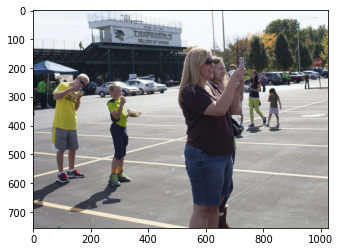

In [6]:
image = dataset_manager.get_img(15)
plt.imshow(bgr2rgb(image))

In [7]:
lisa_predictor = get_obj_shadow_masks_predictor(PATH_TO_LISA_CONFIG)

Config './ComVisProject/LISA-config.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [8]:
lisa_outputs, _ = lisa_predictor.run_on_image(image)

In [9]:
masks = process_lisa_outputs(lisa_outputs)

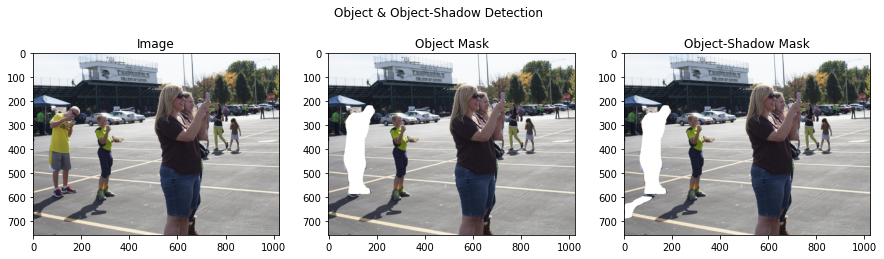

In [10]:
plt.figure(figsize=(15, 4))
plt.suptitle('Object & Object-Shadow Detection')
plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(bgr2rgb(image))
plt.subplot(1, 3, 2)
plt.title('Object Mask')
_ = apply_mask_to_img(image, masks[0][0])
plt.imshow(bgr2rgb(_))
plt.subplot(1, 3, 3)
plt.title('Object-Shadow Mask')
_ = apply_mask_to_img(image, masks[0][1])
plt.imshow(bgr2rgb(_))
plt.show()

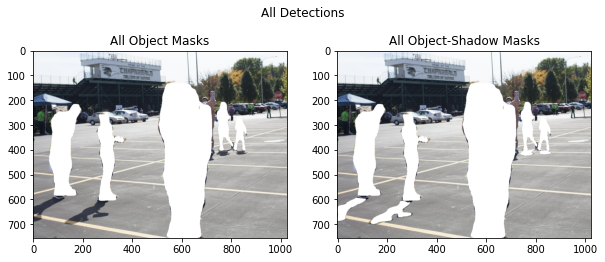

In [11]:
plt.figure(figsize=(10, 4))
plt.suptitle('All Detections')
plt.subplot(1, 2, 1)
plt.title('All Object Masks')
obj_masks = masks[:, :1].squeeze()
res_img = apply_masks_to_img(image, obj_masks)
plt.imshow(bgr2rgb(res_img))
plt.subplot(1, 2, 2)
plt.title('All Object-Shadow Masks')
obj_masks = masks[:, 1:2].squeeze()
res_img = apply_masks_to_img(image, obj_masks)
plt.imshow(bgr2rgb(res_img))
plt.show()

In [12]:
from libs.pconv_model import PConvUnet
pconv_model = PConvUnet(vgg_weights=None, inference_only=True)
pconv_model.load(PATH_TO_PCONV_WEIGHTS, train_bn=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


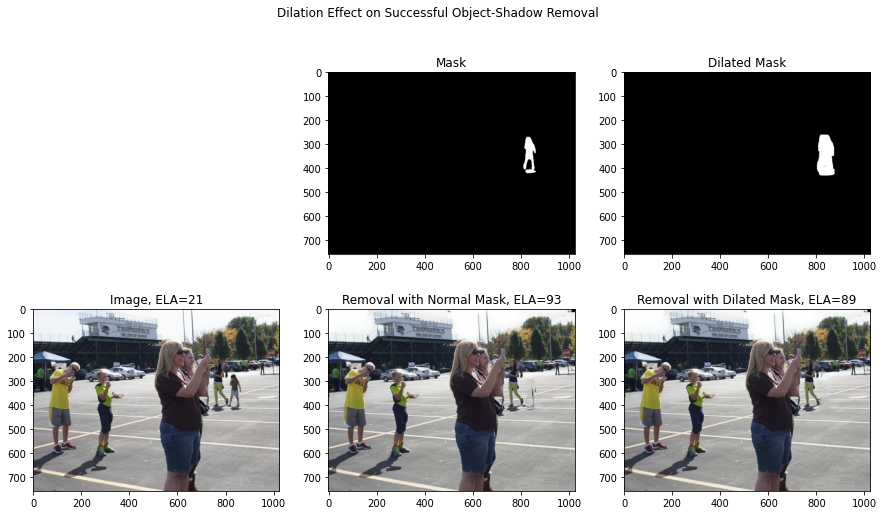

In [13]:
plt.figure(figsize=(15, 8))
plt.suptitle('Dilation Effect on Successful Object-Shadow Removal')
plt.subplot(2, 3, 2)
plt.title('Mask')
plt.imshow(masks[1][1], cmap='gray')
plt.subplot(2, 3, 3)
plt.title('Dilated Mask')
plt.imshow(dilate_mask(masks[1][1]), cmap='gray')
plt.subplot(2, 3, 4)
plt.title(f'Image, ELA={ela(bgr2rgb(image))}')
plt.imshow(bgr2rgb(image))
plt.subplot(2, 3, 5)
inpainted_without_dilation = inpaint(pconv_model, image, masks=[masks[1][1]], dilation=False)
plt.title(f'Removal with Normal Mask, ELA={ela(inpainted_without_dilation)}')
plt.imshow(inpainted_without_dilation)
plt.subplot(2, 3, 6)
inpainted_with_dilation = inpaint(pconv_model, image, masks=[masks[1][1]], dilation=True)
plt.title(f'Removal with Dilated Mask, ELA={ela(inpainted_with_dilation)}')
plt.imshow(inpainted_with_dilation)
plt.show()

In [14]:
from pipeline import LinkedModels
linkedModels = LinkedModels(PATH_TO_LISA_CONFIG, PATH_TO_PCONV_WEIGHTS)

Config './ComVisProject/LISA-config.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [15]:
# remove different objects with object or object-shadow mask types
multiple_obj_removed_img = linkedModels.run_full_pipeline(image, rm_objs=[1, 2], mask_types=[1, 0])

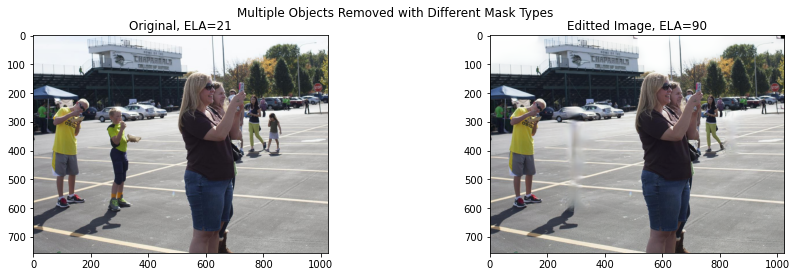

In [16]:
plt.figure(figsize=(15, 4))
plt.suptitle('Multiple Objects Removed with Different Mask Types')
plt.subplot(121)
plt.title(f'Original, ELA={ela(bgr2rgb(image))}')
plt.imshow(bgr2rgb(image))
plt.subplot(122)
plt.title(f'Editted Image, ELA={ela(multiple_obj_removed_img)}')
plt.imshow(multiple_obj_removed_img)
plt.show()

^ Right most person was removed while leaving the shadow while the leftmost person was removed together with their shadow.

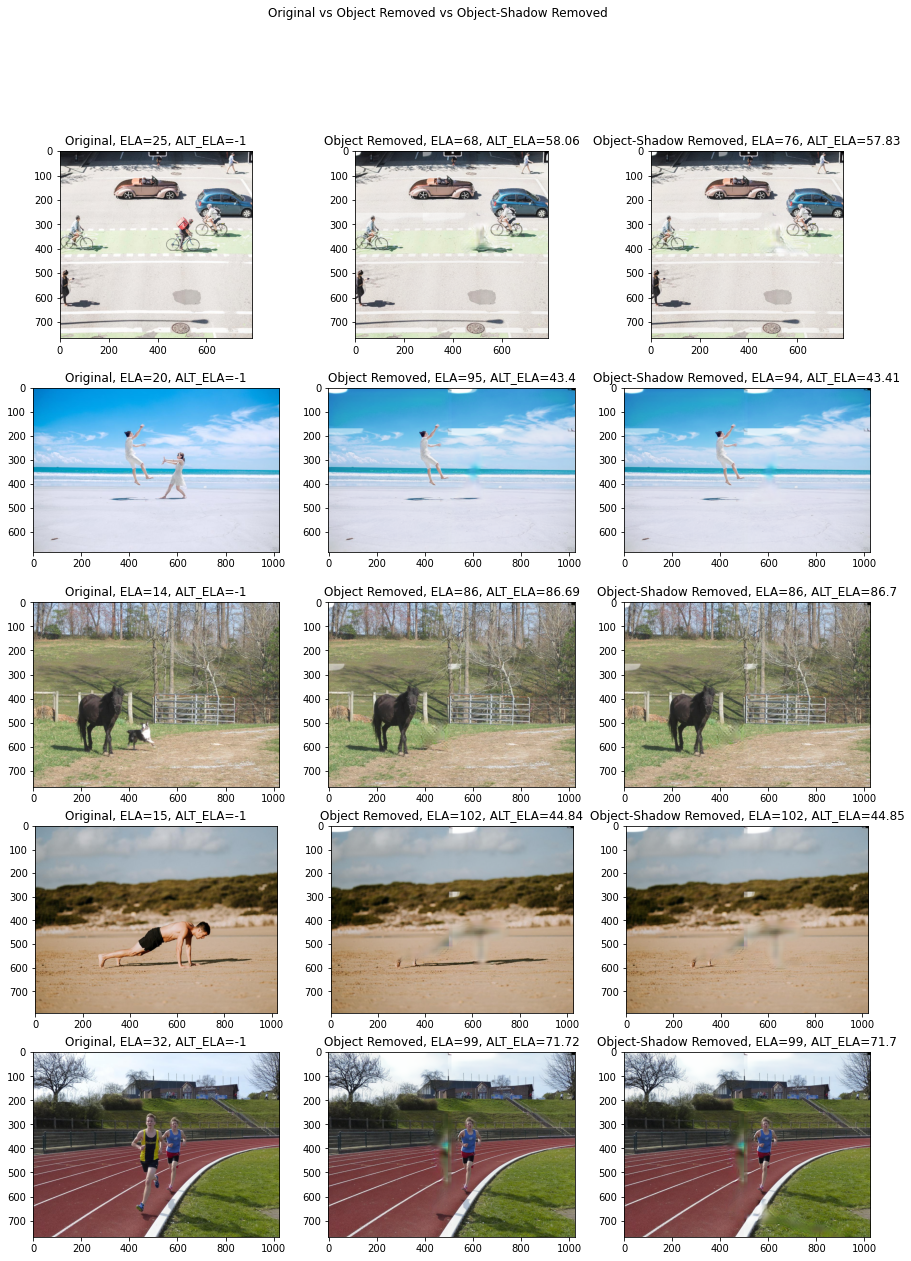

In [17]:
some_more_images = [25, 90, 127, 254, 356]
image_no = len(some_more_images)
images = dataset_manager.get_imgs(some_more_images)

plt.figure(figsize=(15, image_no * 4))
plt.suptitle('Original vs Object Removed vs Object-Shadow Removed')
for i, image in enumerate(images):
  plt.subplot(image_no, 3, i * 3 + 1)
  plt.title(f'Original, ELA={ela(bgr2rgb(image))}, ALT_ELA={-1}')
  plt.imshow(bgr2rgb(image))
  plt.subplot(image_no, 3, i * 3 + 2)
  img_ = linkedModels.run_full_pipeline(image, mask_types=[0])
  plt.imshow(img_)
  plt.title(f'Object Removed, ELA={ela(img_)}, ALT_ELA={rel_alt_ela(img_, bgr2rgb(image))}')
  plt.subplot(image_no, 3, i * 3 + 3)
  img_ = linkedModels.run_full_pipeline(image)
  plt.imshow(img_)
  plt.title(f'Object-Shadow Removed, ELA={ela(img_)}, ALT_ELA={rel_alt_ela(img_, bgr2rgb(image))}')

plt.show()

In [69]:
test_images = dataset_manager.sample_images(800)

In [ ]:
results = []
for i, image in enumerate(test_images):
  obj_removed = linkedModels.run_full_pipeline(image, mask_types=[0])
  obj_shadow_removed = linkedModels.run_full_pipeline(image, mask_types=[1])

  obj_removed_ela = ela(obj_removed)
  obj_shadow_removed_ela = ela(obj_shadow_removed)

  rgb_image = bgr2rgb(image)
  obj_removed_alt_ela = rel_alt_ela(obj_removed, rgb_image)
  obj_shadow_removed_alt_ela = rel_alt_ela(obj_shadow_removed, rgb_image)

  results.append([obj_removed_ela, obj_shadow_removed_ela, obj_removed_alt_ela, obj_shadow_removed_alt_ela])

In [67]:
evaluated_results = eval(results)

In [78]:
import pandas as pd

avg_table = pd.DataFrame({'-':['Object Removal', 'Object-Shadow Removal'], 
                          'Avg ELA': [evaluated_results['ela']['obj_avg'], evaluated_results['ela']['obj_shadow_avg']],
                          'Avg ALT ELA': [evaluated_results['alt_ela']['obj_avg'], evaluated_results['alt_ela']['obj_shadow_avg']]})
avg_table

,-,Avg ELA,Avg ALT ELA
0,Object Removal,69.78,70.34
1,Object-Shadow Removal,66.91,72.77


In [79]:
perf_table = pd.DataFrame({'-':['Obj > Obj-Shadow', 'Obj < Obj-Shadow', 'Obj = Obj-Shadow', 'Total'],
                           'ELA': [evaluated_results['ela']['obj_better'], evaluated_results['ela']['obj_shadow_better'], evaluated_results['ela']['same'], len(results)],
                           'ALT ELA': [evaluated_results['alt_ela']['obj_better'], evaluated_results['alt_ela']['obj_shadow_better'], evaluated_results['alt_ela']['same'], len(results)]})
perf_table

,-,ELA,ALT ELA
0,Obj > Obj-Shadow,217,362
1,Obj < Obj-Shadow,339,232
2,Obj = Obj-Shadow,244,206
3,Total,800,800
